In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')  # Ignoring warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv("defects_data.csv")

# Display basic information about the dataset
print(df.info())

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.any():
    print("Missing values detected in the dataset:")
    print(missing_values)
    
    # Fill missing values with the mean of each column
    df.fillna(df.mean(), inplace=True)
    print("Missing values have been filled with column means.")
else:
    print("No missing values detected in the dataset.")

# Drop irrelevant columns
df = df.drop(columns=['defect_id', 'product_id'])

# Encode categorical target variable
label_encoder = LabelEncoder()
df['severity'] = label_encoder.fit_transform(df['severity'])

# Separate features and target
X = df.drop(columns=['severity'])
y = df['severity']

# Define categorical and numerical features
categorical_features = ['defect_type', 'defect_date', 'defect_location', 'inspection_method']
numerical_features = ['repair_cost']

# Apply One-Hot Encoding to categorical features and scale numerical features
column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaler', StandardScaler(), numerical_features)
])

X_transformed = column_transformer.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

print(df.head())

print("Preprocessing complete. Data is ready for modeling!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   object 
 3   defect_date        1000 non-null   object 
 4   defect_location    1000 non-null   object 
 5   severity           1000 non-null   object 
 6   inspection_method  1000 non-null   object 
 7   repair_cost        1000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB
None
No missing values detected in the dataset.
  defect_type defect_date defect_location  severity  inspection_method  \
0  Structural    6/6/2024       Component         1  Visual Inspection   
1  Functional   4/26/2024       Component         1  Visual Inspection   
2  Structural   2/15/2024        Internal         1  Automated Testing   
3  Funct

Training Accuracy: 0.84
Validation Accuracy: 0.32

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.05}

Training Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83       199
           1       0.80      0.93      0.86       214
           2       0.87      0.76      0.81       187

    accuracy                           0.84       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.84      0.84       600


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.37      0.35       134
           1       0.33      0.33      0.33       144
           2       0.29      0.26      0.27       122

    accuracy                           0.32       400
   macro avg       0.32      0.32      0.32       400
weighted avg       0.32 

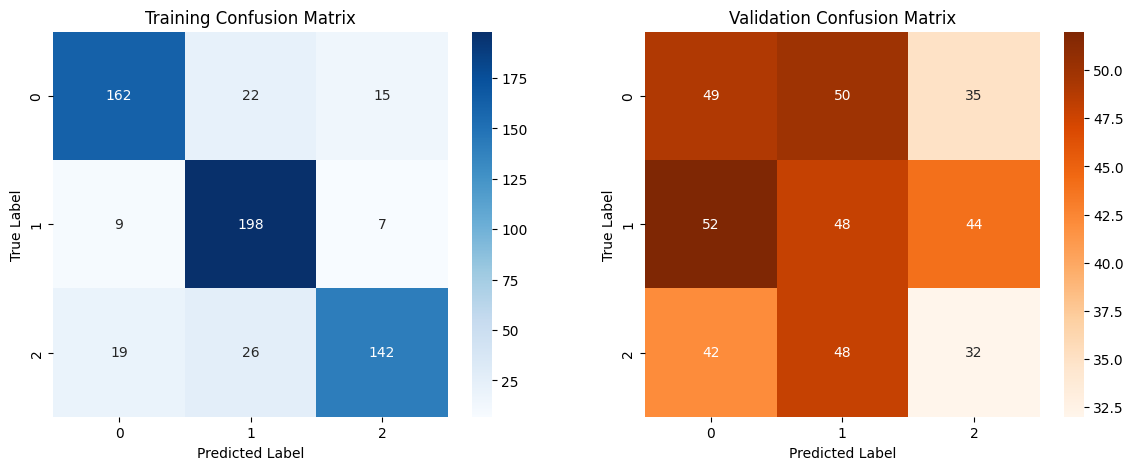

In [17]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # More boosting iterations
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Lower learning rate for stability
    'max_depth': [3, 5, 7, 9],  # Deeper trees for complex relationships
    'min_samples_split': [2, 5, 10],  # Avoid overfitting
    'min_samples_leaf': [1, 2, 5],  # Ensure stable tree growth
    'subsample': [0.8, 1.0],  # Stochastic gradient boosting
}

# Perform Randomized Search for best hyperparameters
gb_model = GradientBoostingClassifier(random_state=42)
random_search = RandomizedSearchCV(
    gb_model, param_grid, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

# Train final model with best parameters
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

# Predictions on training and validation sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {test_accuracy:.2f}")
print("\nBest Hyperparameters:", random_search.best_params_)

# Classification Reports
print("\nTraining Classification Report:\n", classification_report(y_train, y_train_pred))
print("\nValidation Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training Confusion Matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Validation Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title("Validation Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3901 - loss: 1.0961 - val_accuracy: 0.3325 - val_loss: 1.1031
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4565 - loss: 1.0759 - val_accuracy: 0.3325 - val_loss: 1.1073
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4879 - loss: 1.0591 - val_accuracy: 0.3175 - val_loss: 1.1121
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5405 - loss: 1.0292 - val_accuracy: 0.3150 - val_loss: 1.1160
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6114 - loss: 0.9927 - val_accuracy: 0.3200 - val_loss: 1.1273
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6049 - loss: 0.9621 - val_accuracy: 0.3300 - val_loss: 1.1364
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6858 - loss: 0.9025 - val_accuracy: 0.3250 - val_loss: 1.1609
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7284 - loss: 0.8425 - val_accuracy: 0.3200 - val_l

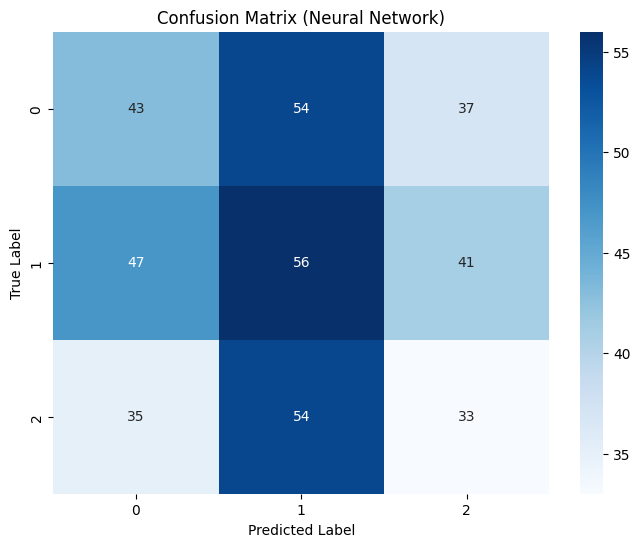

In [20]:
import tensorflow as tf
from tensorflow import keras

# Define neural network
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # 3 classes
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions on test data
y_pred_nn = model.predict(X_test)
y_pred_nn = tf.argmax(y_pred_nn, axis=1)  # Convert probabilities to class predictions

# Evaluate predictions using classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Neural Network)')
plt.show()
